In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set plotting style
sns.set(style='whitegrid')

In [3]:
from google.colab import files

# This will open a file upload dialog in your browser
print("Please select your fraud data CSV file to upload.")
uploaded = files.upload()

# Get the filename of the uploaded file
# This assumes you only upload one file
file_name = next(iter(uploaded))

print(f"\n✅ Successfully uploaded '{file_name}'")


Please select your fraud data CSV file to upload.


Saving Fraud.csv to Fraud.csv

✅ Successfully uploaded 'Fraud.csv'


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('Fraud.csv')

# Step 1: Check and handle missing values
print("Missing values per column:\n", df.isnull().sum())
df = df.dropna()

# Step 2: Handle outliers (using IQR method for 'amount', 'oldbalanceOrg', etc.)
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers at 1st and 99th percentiles
    df[col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))

# Step 3: Handle multi-collinearity
# Create derived features
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg'] + df['amount']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# Drop highly correlated original balance columns
df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1, inplace=True)



Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [7]:
# One-hot encode categorical 'type'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
type_encoded = encoder.fit_transform(df[['type']])
type_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))
df = pd.concat([df.drop('type', axis=1), type_df], axis=1)

# Drop irrelevant columns
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

# Check VIF for remaining numerical features
X = df.drop('isFraud', axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("VIF after cleaning:\n", vif_data)


VIF after cleaning:
          feature       VIF
0           step  1.000996
1         amount  6.537690
2      deltaOrig  5.843983
3      deltaDest  1.242225
4   type_CASH_IN  2.361133
5  type_CASH_OUT  2.353845
6     type_DEBIT  1.019922
7   type_PAYMENT  1.998773
8  type_TRANSFER  2.329751


In [8]:
df.drop('deltaOrig', axis=1, inplace=True)


In [11]:
# Split data into train and validation (70/30)
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
# Import required libraries
import xgboost as xgb  # Import the full module
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV

# Handle imbalance with SMOTE on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize XGBoost model for GridSearchCV
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # Adjusted for imbalance
    objective='binary:logistic',
    random_state=42,
    eval_metric='aucpr'  # Precision-recall AUC for imbalance
)

# Hyperparameter tuning with GridSearchCV (5-fold CV)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=2)  # Reduced n_jobs
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = grid_search.best_estimator_

# Convert data to DMatrix for xgboost.train()
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'learning_rate': best_model.learning_rate,
    'max_depth': best_model.max_depth,
    'subsample': best_model.subsample,
    'colsample_bytree': best_model.colsample_bytree,
    'eval_metric': 'aucpr',
    'scale_pos_weight': 1
}

# Train with early stopping using xgboost.train()
evals = [(dtrain, 'train'), (dval, 'validation')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=best_model.n_estimators,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

# Update best_model with the trained booster and best iteration
best_model._Booster = bst
# Use best_iteration if available, otherwise infer from evals_result
if hasattr(bst, 'best_iteration'):
    best_model.n_estimators = bst.best_iteration + 1  # +1 because iteration is 0-based
else:
    evals_result = bst.evals_result()
    val_scores = evals_result['validation']['aucpr']
    best_iteration = val_scores.index(max(val_scores))
    best_model.n_estimators = best_iteration + 1  # +1 for 1-based index

# Verify the best number of estimators
print(f"Best number of estimators: {best_model.n_estimators}")

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[0]	train-aucpr:0.95466	validation-aucpr:0.00514
[1]	train-aucpr:0.98431	validation-aucpr:0.00520
[2]	train-aucpr:0.98693	validation-aucpr:0.05830
[3]	train-aucpr:0.98616	validation-aucpr:0.03422
[4]	train-aucpr:0.98738	validation-aucpr:0.02238
[5]	train-aucpr:0.98768	validation-aucpr:0.18889
[6]	train-aucpr:0.98781	validation-aucpr:0.22655
[7]	train-aucpr:0.98822	validation-aucpr:0.23766
[8]	train-aucpr:0.98808	validation-aucpr:0.26071
[9]	train-aucpr:0.98790	validation-aucpr:0.21642
[10]	train-aucpr:0.98754	validation-aucpr:0.22778
[11]	train-aucpr:0.98787	validation-aucpr:0.22253
[12]	train-aucpr:0.98808	validation-aucpr:0.22123
[13]	train-aucpr:0.98820	validation-aucpr:0.18136
[14]	train-aucpr:0.98900	validation-aucpr:0.17706
[15]	train-aucpr:0.98889	validation-aucpr:0.16354
[16]	train-aucpr:0.98891	validation-aucpr:0.14742
[17]	train-aucpr:0.98907	validation-aucpr:0.14661
Best number of estimators: 9


Confusion Matrix:
 [[1234727  671595]
 [     72    2392]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79   1906322
           1       0.00      0.97      0.01      2464

    accuracy                           0.65   1908786
   macro avg       0.50      0.81      0.40   1908786
weighted avg       1.00      0.65      0.79   1908786

ROC-AUC: 0.853, PR-AUC: 0.264


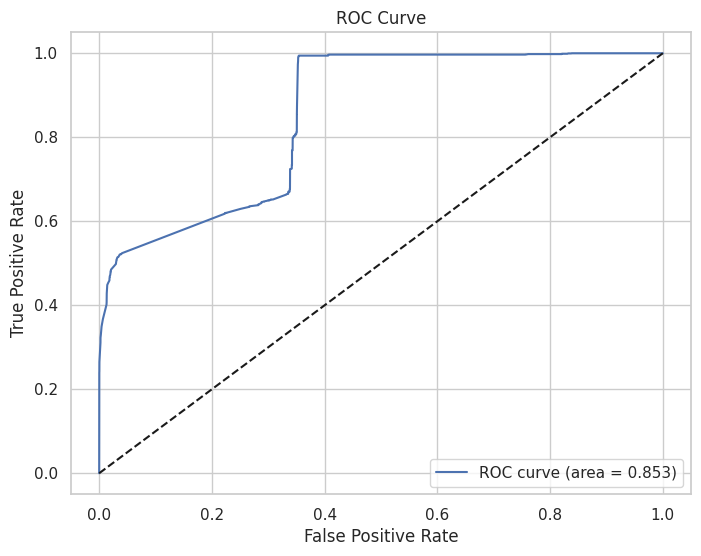

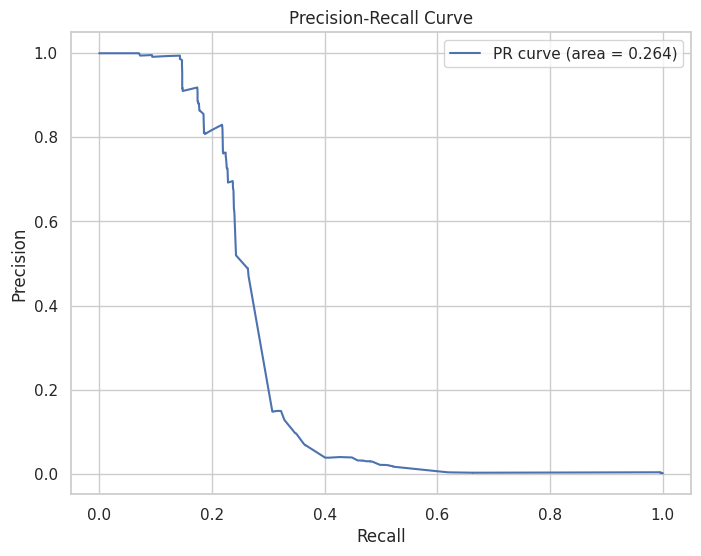

Key Factors Predicting Fraud:
          feature  importance
7  type_TRANSFER    0.324937
6   type_PAYMENT    0.227795
3   type_CASH_IN    0.142820
1         amount    0.106142
4  type_CASH_OUT    0.103968
2      deltaDest    0.060290
0           step    0.031023
5     type_DEBIT    0.003024


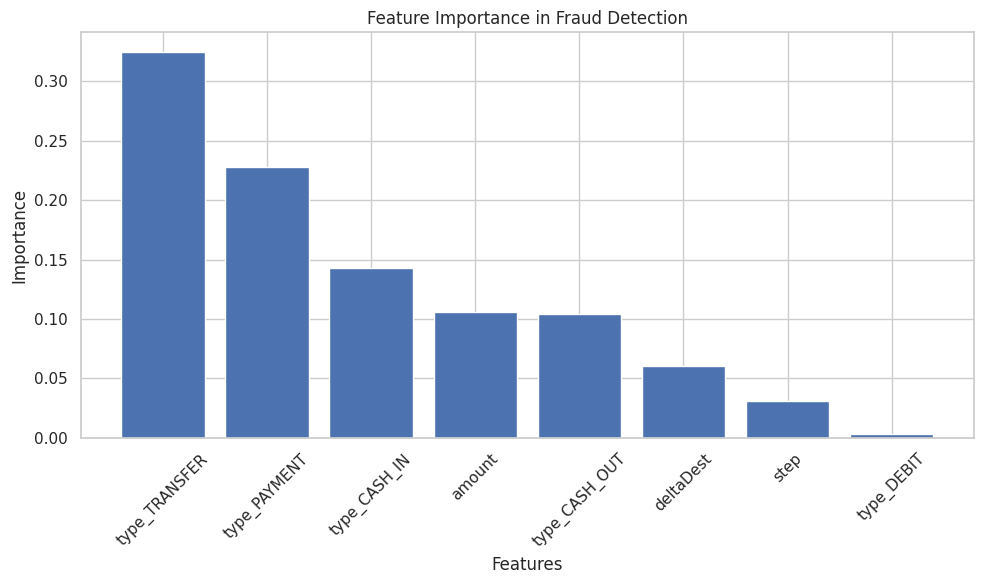

Model saved as 'fraud_detection_model.pkl'


In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
import joblib
# 4. Demonstrate the Performance of the Model
# Predictions
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))

# ROC-AUC and PR-AUC
roc_auc = roc_auc_score(y_val, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"ROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc:.3f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# 5. Key Factors That Predict Fraudulent Customer
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)
print("Key Factors Predicting Fraud:\n", feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance in Fraud Detection')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 8. Save Model for Future Evaluation (Part of Determining Effectiveness)
import joblib
joblib.dump(best_model, 'fraud_detection_model.pkl')
print("Model saved as 'fraud_detection_model.pkl'")

In [22]:
# Example rule-based alert system using model predictions
def generate_alerts(X_new, threshold=0.5):
    y_pred_proba_new = best_model.predict_proba(X_new)[:, 1]
    alerts = pd.DataFrame({
        'transaction_id': X_new.index,
        'probability': y_pred_proba_new,
        'is_alert': y_pred_proba_new > threshold
    })
    return alerts[alerts['is_alert']]

# Apply to new data (e.g., a sample batch)
sample_data = X_val.iloc[:1000].copy()  # Example new data
alerts = generate_alerts(sample_data)
print("Sample Alerts:\n", alerts)

Sample Alerts:
      transaction_id  probability  is_alert
4           2922798     0.645413      True
10           861017     0.634742      True
12           490472     0.538108      True
13          2993914     0.645413      True
14          5564211     0.645413      True
..              ...          ...       ...
985         1002193     0.675309      True
989         3335946     0.645413      True
990         5005018     0.645413      True
997         3088841     0.645413      True
998         1221194     0.677867      True

[365 rows x 3 columns]


In [27]:
# Example rule-based alert system using model predictions
def generate_alerts(X_new, threshold=0.5):
    y_pred_proba_new = best_model.predict_proba(X_new)[:, 1]
    alerts = pd.DataFrame({
        'transaction_id': X_new.index,
        'probability': y_pred_proba_new,
        'is_alert': y_pred_proba_new > threshold
    })
    return alerts[alerts['is_alert']]

# Apply to new data (e.g., a sample batch)
sample_data = X_val.iloc[:1000].copy()  # Example new data
alerts = generate_alerts(sample_data)
print("Sample Alerts:\n", alerts)

Sample Alerts:
      transaction_id  probability  is_alert
4           2922798     0.645413      True
10           861017     0.634742      True
12           490472     0.538108      True
13          2993914     0.645413      True
14          5564211     0.645413      True
..              ...          ...       ...
985         1002193     0.675309      True
989         3335946     0.645413      True
990         5005018     0.645413      True
997         3088841     0.645413      True
998         1221194     0.677867      True

[365 rows x 3 columns]


In [24]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
print("Optimal Threshold:", optimal_threshold)
print("Optimized Classification Report:\n", classification_report(y_val, y_pred_opt))

Optimal Threshold: 0.7744005
Optimized Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.70      0.24      0.35      2464

    accuracy                           1.00   1908786
   macro avg       0.85      0.62      0.68   1908786
weighted avg       1.00      1.00      1.00   1908786

